# Notebook to predict survival of passengers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import survival_funcs as fcs

In [2]:
## scikit-learn
from sklearn.naive_bayes import CategoricalNB, ComplementNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

## tensorflow
import tensorflow as tf

In [3]:
#### User input ####

## path of the train and test data
train_data = "../data/titanic/train.csv"
test_data = "../data/titanic/test.csv"

## path of the test predictions
test_pred_path1 = "../data/titanic/test_pred2.csv"

## the columns used for training
## (SibSp: number of siblings/spouses on board)
## (Parch: number of parents on board)
cols_read = ['PassengerId','Survived', 'Pclass', 'Sex', 'Age','Embarked',
             'SibSp', 'Parch', 'Fare', 'Cabin', 'Ticket']

cols_read_test = ['PassengerId', 'Pclass', 'Sex', 'Age','Embarked',
             'SibSp', 'Parch', 'Fare', 'Cabin', 'Ticket']

## schema for the training dataset
train_schema = {'PassengerId': np.int16,
               'Survived': np.int16,
               'Pclass': np.int16,
               'Sex': str,
               'Age': np.float64,
               'Embarked': str}

## hash maps to convert enum values to numerals
sex_dict = {"female": 1,
           "male": 2}

emb_dict = {"S": 1,
           "Q": 2,
           "C": 3}

In [4]:
## read data into Dataframe
df_train = pd.read_csv(train_data, usecols = cols_read, dtype = train_schema)
df_train.info()

df_test = pd.read_csv(test_data, usecols = cols_read_test, dtype = train_schema)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int16  
 1   Survived     891 non-null    int16  
 2   Pclass       891 non-null    int16  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int16(3), int64(2), object(4)
memory usage: 61.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int16  
 1   Pclass       418 non-null    int16  
 2 

In [5]:
## create numeral values for the enumerated classes
df_train = fcs.trans_cols(df_train, "Sex", "Sex_num", sex_dict)
df_train = fcs.trans_cols(df_train, "Embarked", "Embarked_num", emb_dict)

df_test = fcs.trans_cols(df_test, "Sex", "Sex_num", sex_dict)
df_test = fcs.trans_cols(df_test, "Embarked", "Embarked_num", emb_dict)

## inspect the training data
#df_train.head(10)

## Exploration of the categorical data

In [6]:
## survival rate by number of Pclass
fcs.get_group_probabilities(df_train, "Pclass")

,survival rate,people in group
Pclass,,
1,0.629630,216
2,0.472826,184
3,0.242363,491


In [7]:
## survival rate by number of Sex
fcs.get_group_probabilities(df_train, "Sex")

,survival rate,people in group
Sex,,
female,0.742038,314
male,0.188908,577


In [8]:
## survival rate by number of location of embarkment
fcs.get_group_probabilities(df_train, "Embarked")

,survival rate,people in group
Embarked,,
C,0.553571,168
Q,0.389610,77
S,0.336957,644


In [9]:
## survival rate by number of siblings 
fcs.get_group_probabilities(df_train, "SibSp")

,survival rate,people in group
SibSp,,
0,0.345395,608
1,0.535885,209
2,0.464286,28
3,0.250000,16
4,0.166667,18
5,0.000000,5
8,0.000000,7


In [10]:
## survival rate by number of parents/children on board 
fcs.get_group_probabilities(df_train, "Parch")

,survival rate,people in group
Parch,,
0,0.343658,678
1,0.550847,118
2,0.500000,80
3,0.600000,5
4,0.000000,4
5,0.200000,5
6,0.000000,1


### Conclusions
Both the sex and social class are important parameters to predict whether someone survives. 
Also embarkment seems to play a role survival rate.

## Exploration of the continuous data

### Using direct categorization

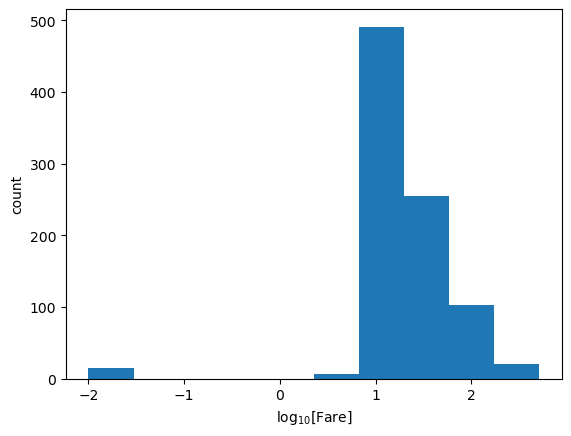

In [11]:
## distribution of the ticket prices
plt.hist(np.log10(df_train["Fare"] + 0.01)) ## +0.01 to avoid zeros

plt.xlabel("log$_{10}$[Fare]")
plt.ylabel("count")
plt.show()

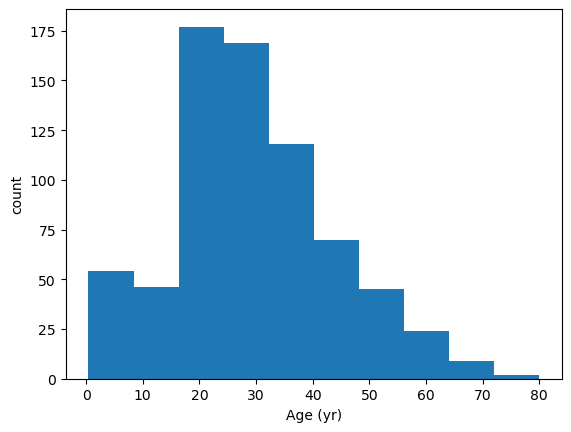

In [12]:
## distribution of the ages
plt.hist(df_train["Age"])

plt.xlabel("Age (yr)")
plt.ylabel("count")
plt.show()

In [13]:
## inspect survival probability as a function of age group
df_train["Decade"] = round(df_train["Age"]/10.)
fcs.get_group_probabilities(df_train, "Decade")

## add 'Decade' to test
df_test["Decade"] = round(df_test["Age"]/10.)

In [14]:
## inspect survival probability as a function of age group
df_train["Price_group"] = round(df_train["Fare"]/10.)
fcs.get_group_probabilities(df_train, "Price_group")

## add 'Price_group' for test
df_test["Price_group"] = round(df_test["Fare"]/10.)

#### conclusions on normalization for deep neural network
Age, fare: either /10 or use log10 when working with a deep model

In [15]:
## remove nans for "Embarked_num" and "Decade"
df_train["Embarked_num"].fillna(0, inplace=True)
df_train["Decade"].fillna(0, inplace=True)
df_train["Age"].fillna(0, inplace=True)

df_test["Embarked_num"].fillna(0, inplace=True)
df_test["Decade"].fillna(0, inplace=True)
df_test["Age"].fillna(0, inplace=True)

/var/folders/pb/xs3f5mtd5bq7lmrql1dj8p040000gn/T/ipykernel_23385/3183022210.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["Embarked_num"].fillna(0, inplace=True)
/var/folders/pb/xs3f5mtd5bq7lmrql1dj8p040000gn/T/ipykernel_23385/3183022210.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

### Inspect the continuous data in a map

In [16]:
## add the log of the price to the data
df_train["log_fare"] = np.log10(df_train["Fare"]+0.01)
df_train["log_age"] = np.log10(df_train["Age"]+0.01)

df_test["log_fare"] = np.log10(df_test["Fare"]+0.01)
df_test["log_age"] = np.log10(df_test["Age"]+0.01)

## Replace the log_fare with the average(only 1 is updated)
# It could be considered using the social class average to include as it can improve accuracy
df_test["log_fare"].fillna(np.nanmean(df_test["log_fare"]), inplace = True)

/var/folders/pb/xs3f5mtd5bq7lmrql1dj8p040000gn/T/ipykernel_23385/1776436672.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test["log_fare"].fillna(np.nanmean(df_test["log_fare"]), inplace = True)


In [17]:
## split the survivors and the people that died
df_tr_survived = df_train[df_train['Survived'] == 1]
df_tr_dead = df_train[df_train['Survived'] == 0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


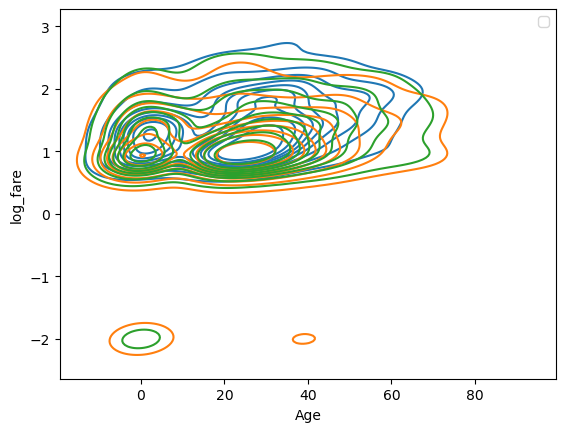

In [18]:
## plot the kde contours for survived and dead (based on aged and fare)
sns.kdeplot(x = df_tr_survived["Age"], y = df_tr_survived["log_fare"], label = 'survived')
sns.kdeplot(x = df_tr_dead["Age"], y = df_tr_dead["log_fare"], label = 'died')
sns.kdeplot(x = df_train["Age"], y = df_train["log_fare"], label = 'died')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


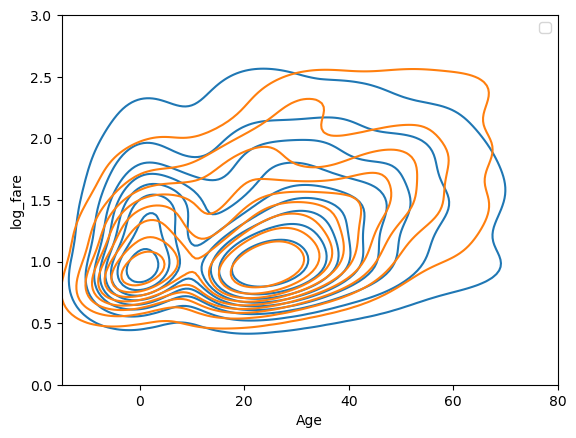

In [19]:
## plot the kde contours for survived and dead (based on aged and fare)
sns.kdeplot(x = df_train["Age"], y = df_train["log_fare"], label = 'training data')
sns.kdeplot(x = df_test["Age"], y = df_test["log_fare"], label = 'test data')

plt.xlim([-15, 80])
plt.ylim([0, 3])
plt.legend()
plt.show()

### Cluster the Age - log(Fare) with GMM

In [20]:
## import the Gaussian Mixture Model from Scikit-learn
from sklearn.mixture import GaussianMixture

## input for the Gaussian Mixture Models
num_comps_min = 2 
num_comps_max = 10
seed_val = 108  ## Seed to initialize the GMM
init_param_method = "kmeans" ## Method to initialize the weights and means of the GMM

In [21]:
## prepare the data for clustering
clust_data = df_train[["Age", "log_fare"]].to_numpy()

In [22]:
## storage list for the GMM fitting results
BIC_list = [] ## stores the Bayesian Information Criterion (BIC) values for each fit
num_comps_list = [] ## stores the number of components fitted
min_BIC = np.nan  ## stores the minimal BIC_value
best_model = None  ## stores the best GMM model

In [23]:
## identify the number of GMM clusters
for num in range(num_comps_min, num_comps_max):
    ## created a fitted model
    model = GaussianMixture(n_components=num, init_params=init_param_method, random_state=seed_val).fit(clust_data)

    ## calculate the BIC
    BIC = model.bic(clust_data)
    
    ## store the results from the model
    if(np.isnan(min_BIC) or BIC < min_BIC):
        min_BIC = BIC
        best_model = model
    BIC_list.append(BIC)
    num_comps_list.append(num)  

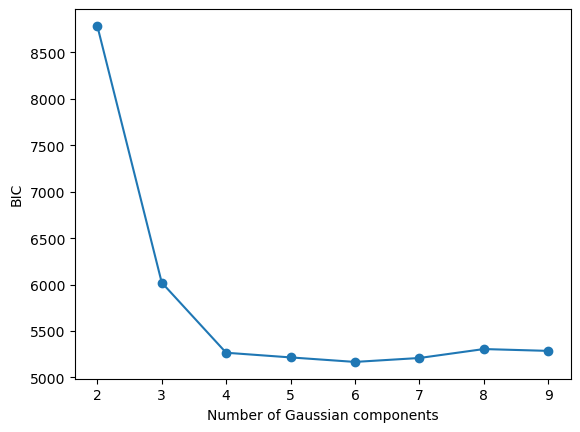

In [24]:
## Plot the BIC values as a function of the number of clusters to see the trend
plt.plot(num_comps_list, BIC_list,"-o")

plt.xlabel("Number of Gaussian components")
plt.ylabel("BIC")

plt.show()

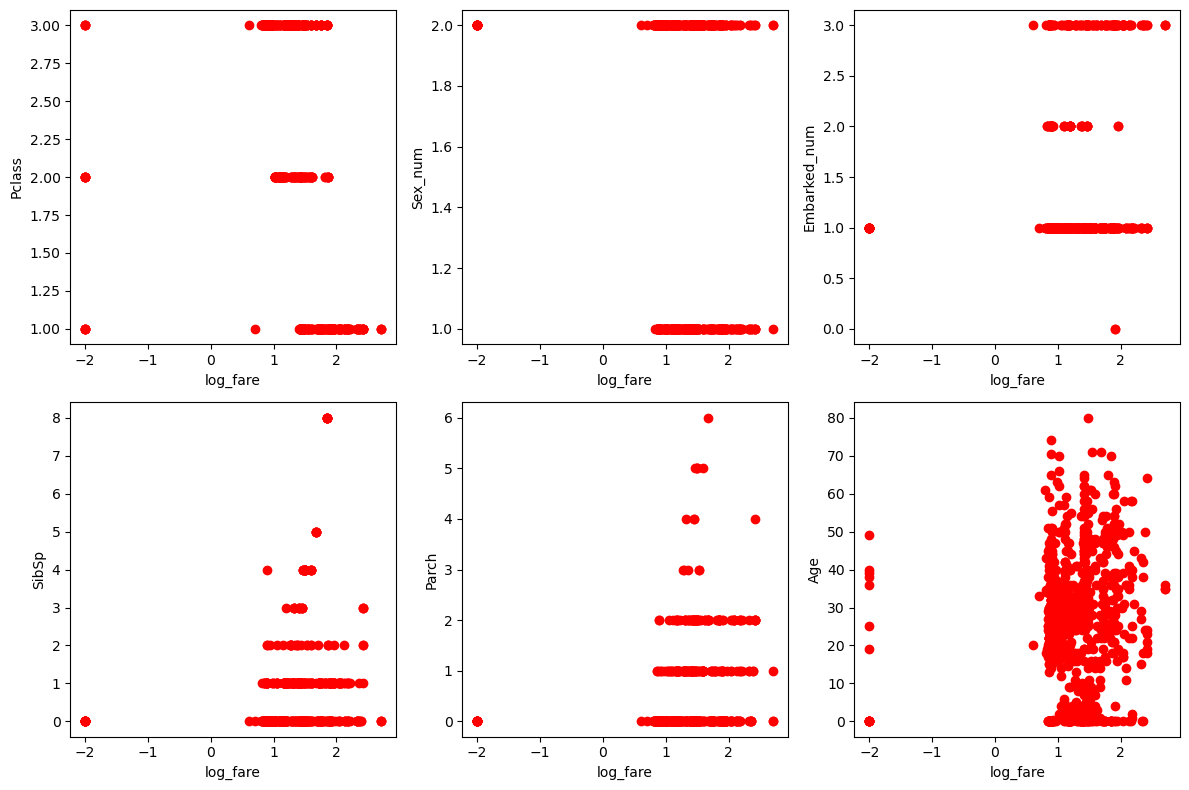

In [25]:
## plot correlations between log of the Fare and other parameters
plot_params = ["Pclass", "Sex_num", "Embarked_num", "SibSp", "Parch", "Age"]
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8))
for idx, param in enumerate(plot_params):
    axs[idx//3][idx%3].plot(df_train["log_fare"], df_train[param], 'ro')
    axs[idx//3][idx%3].set_xlabel("log_fare")
    axs[idx//3][idx%3].set_ylabel(param)

plt.tight_layout()
plt.show()

In [26]:
## create the cluster tags and store them in the DataFrame
cluster_tags_train = best_model.predict(clust_data)
df_train["GMM_clusts"] = cluster_tags_train

## also store the cluster tags for the test data
df_test["GMM_clusts"] = best_model.predict(df_test[["Age", "log_fare"]].to_numpy())

In [27]:
## survival rate by number of siblings 
fcs.get_group_probabilities(df_train, "GMM_clusts")

,survival rate,people in group
GMM_clusts,,
0,0.571429,63
1,0.066667,15
2,0.222222,180
3,0.307692,169
4,0.530822,292
5,0.337209,172


## Naive Bayes categorical

### Using categories with no missing values

In [28]:
## initiate the weights of the class
df_sum = df_train["Survived"].sum()
survivors_frac = df_sum/len(df_train)
class_weights = [1. - survivors_frac, survivors_frac]

In [29]:
## create input data
cols1 = ["Pclass", "Sex_num"]#, "SibSp", "Parch"]
X1 = fcs.get_features(df_train, cols1)
Y1 = np.array(df_train["Survived"])

## create categorical Bayes object
clf1 = CategoricalNB()

## create model 1 and predict the results
model1 = clf1.fit(X1, Y1)
results1 = model1.predict(X1)

In [30]:
## print the accuracy
print(model1.score(X1, Y1))

0.7867564534231201


In [31]:
## make the prediction for the test set
X1_test = fcs.get_features(df_test, cols1)
test_1 = model1.predict(X1_test)

In [32]:
## add test predictions to the test dataframe
df_test["Survived"] = test_1

## write results to csv file
to_write = ["PassengerId", "Survived"]
#df_test.to_csv(test_pred_path1, columns = to_write, index = False)

### Also including categories with missing values

In [33]:
## create input data
X2 = fcs.get_features(df_train, ["Pclass", "Sex_num", "Embarked_num", "SibSp", "Parch"])

## minumum number of classes for each 
## prevents error when running predictions on the test data which has categories that are not present in the training data
min_cats = np.array([3, 2, 4, 10, 10])

## create categorical Bayes object
clf2 = CategoricalNB(min_categories = min_cats)

## create model 1 and predict the results
model2 = clf2.fit(X2, Y1)
results2 = model2.predict(X2)

In [34]:
## print the accuracy
print(model2.score(X2, Y1))

0.7946127946127947


In [35]:
## make the prediction for the test set
X2_test = fcs.get_features(df_test, ["Pclass", "Sex_num", "Embarked_num", "SibSp", "Parch"])
test_2 = model2.predict(X2_test)

In [36]:
## add test predictions to the test dataframe
#df_test["Survived"] = test_2

## write results to csv file
#to_write = ["PassengerId", "Survived"]
#df_test.to_csv(test_pred_path1, columns = to_write, index = False)

## Include Fare and Age categories 

In [37]:
## create categorical Bayes object
clf3 = CategoricalNB()

## create input data
X3 = fcs.get_features(df_train, ["Pclass", "Sex_num", "Embarked_num", "SibSp", "Parch", "Price_group", "Decade"])

## create model 1 and predict the results
model3 = clf3.fit(X3, Y1)
results3 = model3.predict(X3)

In [38]:
## print the accuracy
print(model3.score(X3, Y1))

0.7721661054994389


## Include GMM clusters instead of Fare and Age

In [39]:
## create categorical Bayes object
clf4 = CategoricalNB()

## create input data
X4 = fcs.get_features(df_train, ["Pclass", "Sex_num", "Embarked_num", "SibSp", "Parch", "GMM_clusts"])

## create model 1 and predict the results
model4 = clf4.fit(X4, Y1)
results4 = model4.predict(X4)

In [40]:
## print the accuracy
print(model4.score(X4, Y1))

0.7676767676767676


## Random forest classifier

In [41]:
## Create random forest classifier for X2 data set
rf_clf1 = RandomForestClassifier(max_depth=3)

## fit and predict
rf_model1 = rf_clf1.fit(X2, Y1)
rf_result1 = rf_clf1.predict(X2)

In [42]:
## print the accuracy
print(rf_model1.score(X2, Y1))

0.8092031425364759


In [43]:
## perform on the test data
#rf_test_1 = rf_model1.predict(X2_test)

In [44]:
## add test predictions to the test dataframe
#df_test["Survived"] = rf_test_1

## write results to csv file
#to_write = ["PassengerId", "Survived"]
#df_test.to_csv("../data/titanic/test_pred3.csv", columns = to_write, index = False)

In [45]:
## Create random forest classifier for data set with GMM clustering
rf_clf2 = RandomForestClassifier(max_depth = 6)

## fit and predict
rf_model2 = rf_clf1.fit(X4, Y1)
rf_result2 = rf_clf1.predict(X4)

In [46]:
## print the accuracy
print(rf_model2.score(X4, Y1))

0.8204264870931538


In [47]:
## perform on the test data
X4_test = fcs.get_features(df_test, ["Pclass", "Sex_num", "Embarked_num", "SibSp", "Parch", "GMM_clusts"])
rf_test_2 = rf_model2.predict(X4_test)

In [48]:
## add test predictions to the test dataframe
#df_test["Survived"] = rf_test_2

## write results to csv file
#to_write = ["PassengerId", "Survived"]
#df_test.to_csv("../data/titanic/test_pred4.csv", columns = to_write, index = False)

## Create a Tensorflow model

In [49]:
from tensorflow.keras.losses import CategoricalCrossentropy

In [50]:
## create the one_hot encoding
indices = [0, 1]
depth = len(indices)
Y1_oh = tf.one_hot(Y1, depth)

In [51]:
## create input data
X4 = fcs.get_features(df_train, ["Pclass", "Sex_num", "Embarked_num", "SibSp", "Parch", "log_fare", "log_age"])
print(X4.shape)
print(Y1_oh.shape)

## create the model
tf_model = tf.keras.Sequential()
tf_model.add(tf.keras.Input(shape=(7,)))
tf_model.add(tf.keras.layers.Dropout(0.1))
tf_model.add(tf.keras.layers.Dense(16, activation="linear", use_bias = True))
tf_model.add(tf.keras.layers.Dense(32, activation="linear", use_bias = True))
tf_model.add(tf.keras.layers.Dense(64, activation="linear", use_bias = True))
tf_model.add(tf.keras.layers.Dense(64, activation="relu", use_bias = True))
tf_model.add(tf.keras.layers.Dense(64, activation="relu", use_bias = True))
tf_model.add(tf.keras.layers.Dense(16, activation="relu", use_bias = True))
tf_model.add(tf.keras.layers.Dense(2, activation="softmax"))

## compile the model
tf_model.compile(optimizer = 'adam', loss = CategoricalCrossentropy(), metrics = ["accuracy"])

## fit the model
tf_model.fit(X4, Y1_oh, batch_size=16, epochs = 10)

(891, 7)
(891, 2)
Epoch 1/10


2024-04-11 17:49:32.995516: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


56/56 [==============================] - 0s 743us/step - loss: 0.5697 - accuracy: 0.7149
Epoch 2/10
56/56 [==============================] - 0s 568us/step - loss: 0.5646 - accuracy: 0.7250
Epoch 3/10
56/56 [==============================] - 0s 448us/step - loss: 0.5213 - accuracy: 0.7531
Epoch 4/10
56/56 [==============================] - 0s 488us/step - loss: 0.5176 - accuracy: 0.7475
Epoch 5/10
56/56 [==============================] - 0s 454us/step - loss: 0.5126 - accuracy: 0.7452
Epoch 6/10
56/56 [==============================] - 0s 454us/step - loss: 0.4846 - accuracy: 0.7778
Epoch 7/10
56/56 [==============================] - 0s 443us/step - loss: 0.4940 - accuracy: 0.7587
Epoch 8/10
56/56 [==============================] - 0s 447us/step - loss: 0.4789 - accuracy: 0.7733
Epoch 9/10
56/56 [==============================] - 0s 445us/step - loss: 0.4819 - accuracy: 0.7845
Epoch 10/10
56/56 [==============================] - 0s 423us/step - loss: 0.4845 - accuracy: 0.7688


28/28 [==============================] - 0s 323us/step


(array([ 98., 430., 160., 110.,  93.,  93., 110., 160., 430.,  98.]),
 array([0.01686868, 0.11349494, 0.2101212 , 0.30674747, 0.40337372,
        0.49999997, 0.5966262 , 0.6932525 , 0.7898788 , 0.886505  ,
        0.9831313 ], dtype=float32),
 <BarContainer object of 10 artists>)

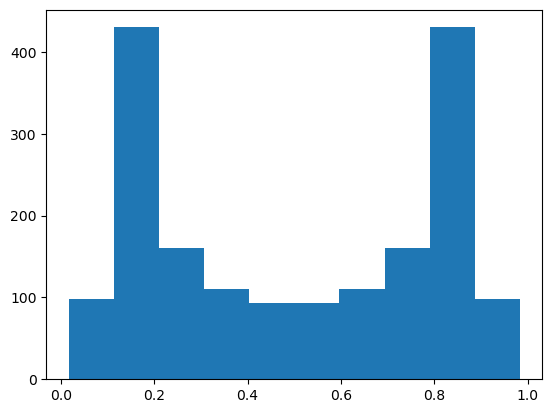

In [52]:
## plot the histogram of the probabilities
pred_probs = tf_model.predict(X4)
plt.hist(pred_probs.ravel())